In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import requests
import numpy as np
import seaborn as sns

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)


True

In [ ]:
API_KEY = "your_api_key_here"  # Replace with your TMDB API key

def fetch_movie_reviews(movie_id, api_key):
    """
    Fetch reviews from TMDB API for a specific movie
    """
    url = f"https://api.themoviedb.org/3/movie/{movie_id}/reviews"
    params = {"api_key": api_key, "page": 1}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        return data.get('results', [])
    except Exception as e:
        print(f"Error fetching reviews: {e}")
        return []

def fetch_movie_details(movie_id, api_key):
    """
    Fetch movie details (title, release date, etc.) from TMDB API
    """
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    params = {"api_key": api_key}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching movie details: {e}")
        return {}


In [107]:
# Load existing data
data = pd.read_csv('Movie_Review.csv')
print(f"Original data shape: {data.shape}")
print(f"Sentiment distribution:\n{data['sentiment'].value_counts()}")


Original data shape: (1000, 2)
Sentiment distribution:
sentiment
neg    500
pos    500
Name: count, dtype: int64


In [ ]:
sia = SentimentIntensityAnalyzer()

def classify_sentiment_vader(text):
    """
    Classify sentiment as positive, negative, or neutral using VADER
    """
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'pos'
    elif score <= -0.05:
        return 'neg'
    else:
        return 'neutral'

# Apply VADER labeling to create 3-class dataset
print("Labeling reviews with VADER sentiment analyzer...")
data['vader_sentiment'] = data['text'].apply(classify_sentiment_vader)
print(f"New sentiment distribution:\n{data['vader_sentiment'].value_counts()}")

# Use the vader_sentiment for 3-class classification
data['sentiment'] = data['vader_sentiment']


Labeling reviews with VADER sentiment analyzer...
New sentiment distribution:
vader_sentiment
pos        657
neg        339
neutral      4
Name: count, dtype: int64


In [109]:
# Data cleaning - remove NaN values
data.dropna(inplace=True)
print(f"Data shape after dropping NaN: {data.shape}")


Data shape after dropping NaN: (1000, 3)


In [110]:
# Text preprocessing using NLTK - same method as source file
def clean_review(review):
    """
    Remove stopwords from the review text
    """
    stop_words = set(stopwords.words('english'))
    cleaned = ' '.join(word for word in review.split() if word.lower() not in stop_words)
    return cleaned

# Apply cleaning
print("Cleaning text data...")
data['text'] = data['text'].apply(clean_review)
print("Text preprocessing completed!")


Cleaning text data...
Text preprocessing completed!


In [111]:
# Feature extraction using TF-IDF - same as source file
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
cv = TfidfVectorizer(max_features=2500)
print("Creating TF-IDF features...")

# Transform the text data
reviews = cv.fit_transform(data['text']).toarray()
print(f"Feature matrix shape: {reviews.shape}")


Creating TF-IDF features...
Feature matrix shape: (1000, 2500)


In [112]:
# Convert sentiment labels to numeric: pos=2, neutral=1, neg=0
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['sentiment_numeric'] = le.fit_transform(data['sentiment'])
print(f"Sentiment encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"Final distribution:\n{data['sentiment'].value_counts()}")


Sentiment encoding: {'neg': np.int64(0), 'neutral': np.int64(1), 'pos': np.int64(2)}
Final distribution:
sentiment
pos        657
neg        339
neutral      4
Name: count, dtype: int64


In [113]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    reviews, 
    data['sentiment_numeric'], 
    test_size=0.2, 
    random_state=42,
    stratify=data['sentiment_numeric']  # Maintain class distribution
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training sentiment distribution:\n{pd.Series(y_train).value_counts()}")


Training set size: (800, 2500)
Test set size: (200, 2500)
Training sentiment distribution:
sentiment_numeric
2    526
0    271
1      3
Name: count, dtype: int64


In [114]:
# Train Logistic Regression model for 3-class classification
from sklearn.linear_model import LogisticRegression

# Create and train the model
model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
print("Training the model...")
model.fit(X_train, y_train)
print("Model training completed!")


Training the model...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model training completed!


In [115]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Model Performance:
Accuracy: 0.7050

Classification Report:
              precision    recall  f1-score   support

         neg       0.73      0.24      0.36        68
     neutral       0.00      0.00      0.00         1
         pos       0.70      0.95      0.81       131

    accuracy                           0.70       200
   macro avg       0.48      0.40      0.39       200
weighted avg       0.71      0.70      0.65       200



c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

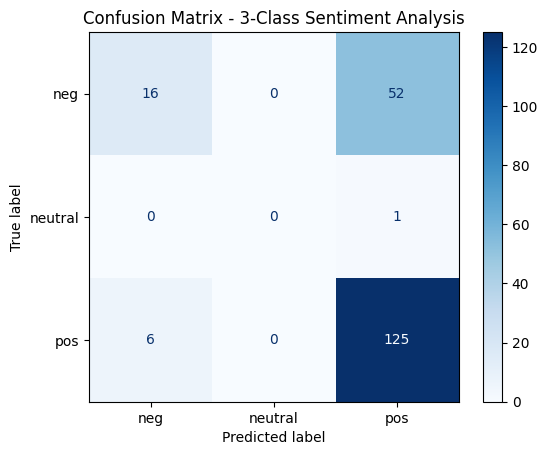

In [116]:
# Visualize confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - 3-Class Sentiment Analysis')
plt.show()


In [117]:
# Function to predict sentiment for new reviews
def predict_sentiment(review_text):
    """
    Predict sentiment (positive, negative, or neutral) for a given review
    
    Args:
        review_text: String containing the movie review
    
    Returns:
        Dictionary with prediction and probabilities
    """
    # Clean the review
    cleaned_review = clean_review(review_text)
    
    # Transform using TF-IDF
    review_vector = cv.transform([cleaned_review]).toarray()
    
    # Make prediction
    prediction_numeric = model.predict(review_vector)[0]
    prediction_label = le.inverse_transform([prediction_numeric])[0]
    
    # Get probabilities
    probabilities = model.predict_proba(review_vector)[0]
    prob_dict = {label: prob for label, prob in zip(le.classes_, probabilities)}
    
    return {
        'sentiment': prediction_label,
        'probabilities': prob_dict,
        'confidence': max(probabilities)
    }

# Test the function with sample reviews
sample_reviews = [
    "This movie is absolutely fantastic! I loved every minute of it.",
    "The movie was terrible and boring. Waste of time.",
    "The movie was okay. Nothing special but not bad either."
]

print("Sample Predictions:")
print("-" * 50)
for review in sample_reviews:
    result = predict_sentiment(review)
    print(f"\nReview: {review}")
    print(f"Predicted Sentiment: {result['sentiment'].upper()}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: {result['probabilities']}")
    print("-" * 50)


Sample Predictions:
--------------------------------------------------

Review: This movie is absolutely fantastic! I loved every minute of it.
Predicted Sentiment: POS
Confidence: 0.7454
Probabilities: {'neg': np.float64(0.2503328736928427), 'neutral': np.float64(0.004309469482883238), 'pos': np.float64(0.745357656824274)}
--------------------------------------------------

Review: The movie was terrible and boring. Waste of time.
Predicted Sentiment: NEG
Confidence: 0.6933
Probabilities: {'neg': np.float64(0.6933201394476717), 'neutral': np.float64(0.0039195163913309725), 'pos': np.float64(0.3027603441609974)}
--------------------------------------------------

Review: The movie was okay. Nothing special but not bad either.
Predicted Sentiment: NEG
Confidence: 0.5076
Probabilities: {'neg': np.float64(0.5076390942611271), 'neutral': np.float64(0.004456299769912811), 'pos': np.float64(0.4879046059689602)}
--------------------------------------------------


In [118]:
# Save the model and vectorizer
import pickle

# Save model
with open('movie_review_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save TF-IDF vectorizer
with open('movie_review_vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

# Save label encoder
with open('movie_review_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and related files saved successfully!")
print("Files created:")
print("- movie_review_model.pkl")
print("- movie_review_vectorizer.pkl")
print("- movie_review_label_encoder.pkl")


Model and related files saved successfully!
Files created:
- movie_review_model.pkl
- movie_review_vectorizer.pkl
- movie_review_label_encoder.pkl


In [ ]:
# Load and use the saved model for predictions (for future use)
def load_model_and_predict(review_text):
    """
    Load saved model and make predictions
    Use this function when you want to load the model from disk
    """
    # Load model
    with open('movie_review_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    
    # Load vectorizer
    with open('movie_review_vectorizer.pkl', 'rb') as f:
        loaded_cv = pickle.load(f)
    
    # Load label encoder
    with open('movie_review_label_encoder.pkl', 'rb') as f:
        loaded_le = pickle.load(f)
    
    # Clean and predict
    cleaned_review = clean_review(review_text)
    review_vector = loaded_cv.transform([cleaned_review]).toarray()
    prediction_numeric = loaded_model.predict(review_vector)[0]
    prediction_label = loaded_le.inverse_transform([prediction_numeric])[0]
    
    return prediction_label

print("Model loading function created.")


Model loading function created. You can use it to make predictions on new reviews.


In [ ]:
# List of popular movie IDs to fetch reviews from
movie_ids = [550, 157336, 475557, 181808, 19404, 238, 424]  # Example movie IDs

api_key = "97e907bb9ccb43ba35d87249a2223f1c"  # Replace with your API key

additional_reviews = []

for movie_id in movie_ids:
    print(f"Fetching reviews for movie ID: {movie_id}")
    reviews = fetch_movie_reviews(movie_id, api_key)
    
    for review_data in reviews:
        review_text = review_data.get('content', '')
        if review_text:  # Only add non-empty reviews
            sentiment = classify_sentiment_vader(review_text)
            additional_reviews.append({
                'text': review_text,
                'sentiment': sentiment
            })
    
    print(f"Fetched {len(reviews)} reviews")

# Create DataFrame from additional reviews
additional_df = pd.DataFrame(additional_reviews)

# Combine with existing data
data = pd.concat([data, additional_df], ignore_index=True)
print(f"\nTotal reviews after adding API data: {len(data)}")
print(f"Sentiment distribution:\n{data['sentiment'].value_counts()}")

print("This cell is ready for use if you want to fetch additional data from TMDB API")


Fetching reviews for movie ID: 550
Fetched 10 reviews
Fetching reviews for movie ID: 157336
Fetched 18 reviews
Fetching reviews for movie ID: 475557
Fetched 18 reviews
Fetching reviews for movie ID: 181808
Fetched 16 reviews
Fetching reviews for movie ID: 19404
Fetched 1 reviews
Fetching reviews for movie ID: 238
Fetched 6 reviews
Fetching reviews for movie ID: 424
Fetched 4 reviews

Total reviews after adding API data: 1073
Sentiment distribution:
sentiment
pos        709
neg        360
neutral      4
Name: count, dtype: int64
This cell is ready for use if you want to fetch additional data from TMDB API


In [ ]:
# Fetch and Display Movie Reviews with Sentiment Analysis
API_KEY_FOR_FETCH = "97e907bb9ccb43ba35d87249a2223f1c"  # Replace with your TMDB API key
MOVIE_ID = 550  # Example: 550 is Fight Club (change to any movie ID you want)

def fetch_movie_details(movie_id, api_key):
    """
    Fetch movie details (title, release date, etc.) from TMDB API
    """
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    params = {"api_key": api_key}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching movie details: {e}")
        return {}

def fetch_movie_reviews(movie_id, api_key):
    """
    Fetch reviews from TMDB API for a specific movie
    """
    url = f"https://api.themoviedb.org/3/movie/{movie_id}/reviews"
    params = {"api_key": api_key, "page": 1}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        return data.get('results', [])
    except Exception as e:
        print(f"Error fetching reviews: {e}")
        return []

def display_movie_reviews_with_sentiment(movie_id, api_key):
    """
    Fetch movie reviews from TMDB API and display them with sentiment analysis
    """
    # Fetch movie details to get the movie name
    movie_details = fetch_movie_details(movie_id, api_key)
    movie_title = movie_details.get('title', f'Movie ID: {movie_id}')
    movie_year = movie_details.get('release_date', '')[:4] if movie_details.get('release_date') else ''
    
    # Fetch reviews
    reviews = fetch_movie_reviews(movie_id, api_key)
    
    if not reviews:
        print(f"No reviews found for Movie ID: {movie_id}")
        print("Possible reasons:")
        print("- Invalid API key")
        print("- Movie ID doesn't exist")
        print("- The movie has no reviews")
        return
    
    print(f"\n{'=' * 80}")
    print(f"MOVIE: {movie_title} ({movie_year})")
    print(f"{'=' * 80}")
    print(f"Found {len(reviews)} reviews\n")
    print("=" * 80)
    
    # Display each review with sentiment
    for idx, review_data in enumerate(reviews, 1):
        review_text = review_data.get('content', 'N/A')
        
        # Classify sentiment
        sentiment_result = predict_sentiment(review_text)
        
        # Display the review
        print(f"\n{'#' * 80}")
        print(f"REVIEW #{idx}")
        print(f"{'#' * 80}")
        print(f"\nMovie: {movie_title}")
        print(f"{'─' * 80}")
        print("Review:")
        print(f"{'─' * 80}")
        print(review_text)
        print(f"{'─' * 80}")
        print(f"\nResult: {sentiment_result['sentiment'].upper()}")
        print(f"Confidence: {sentiment_result['confidence']:.2%}")
        print(f"Probabilities:")
        for sentiment, prob in sentiment_result['probabilities'].items():
            print(f"  {sentiment:8s}: {prob:6.2%}")
        print(f"{'#' * 80}\n")

# Call the function to fetch and display reviews
display_movie_reviews_with_sentiment(MOVIE_ID, API_KEY_FOR_FETCH)


MOVIE: Fight Club (1999)
Found 10 reviews


################################################################################
REVIEW #1
################################################################################

Movie: Fight Club
────────────────────────────────────────────────────────────────────────────────
Review:
────────────────────────────────────────────────────────────────────────────────
Pretty awesome movie.  It shows what one crazy person can convince other crazy people to do.  Everyone needs something to believe in.  I recommend Jesus Christ, but they want Tyler Durden.
────────────────────────────────────────────────────────────────────────────────

Result: POS
Confidence: 76.60%
Probabilities:
  neg     : 23.05%
  neutral :  0.35%
  pos     : 76.60%
################################################################################


################################################################################
REVIEW #2
##############################################

In [ ]:
import re
import numpy as np
from sklearn.ensemble import IsolationForest

# Ensure tokenizer is available
nltk.download('punkt', quiet=True)

url_pattern = re.compile(r"https?://|www\.")


def safe_div(a, b):
    return float(a) / float(b) if b else 0.0


def extract_review_features(text: str) -> np.ndarray:
    if not isinstance(text, str):
        text = ""
    tokens = nltk.word_tokenize(text)
    words = [t for t in tokens if t.isalpha()]
    num_chars = len(text)
    num_words = len(words)
    unique_words = len(set(w.lower() for w in words))
    avg_word_len = float(np.mean([len(w) for w in words])) if words else 0.0
    type_token_ratio = safe_div(unique_words, num_words)
    sw = set(stopwords.words('english'))
    stopword_ratio = safe_div(sum(1 for w in words if w.lower() in sw), num_words)
    punctuation_ratio = safe_div(sum(1 for ch in text if not ch.isalnum() and not ch.isspace()), max(1, num_chars))
    uppercase_ratio = safe_div(sum(1 for w in words if w.isupper() and len(w) > 1), max(1, num_words))
    digit_ratio = safe_div(sum(1 for ch in text if ch.isdigit()), max(1, num_chars))
    url_count = len(url_pattern.findall(text))
    repeated_char_ratio = safe_div(len(re.findall(r"(.)\1{2,}", text)), max(1, num_chars))
    # sentence stats
    try:
        sentences = nltk.sent_tokenize(text)
        sentence_word_counts = [len(nltk.word_tokenize(s)) for s in sentences] if sentences else []
        avg_sentence_len = float(np.mean(sentence_word_counts)) if sentence_word_counts else 0.0
    except Exception:
        avg_sentence_len = 0.0
    return np.array([
        num_chars,
        num_words,
        avg_word_len,
        type_token_ratio,
        stopword_ratio,
        punctuation_ratio,
        uppercase_ratio,
        digit_ratio,
        url_count,
        repeated_char_ratio,
        avg_sentence_len,
    ], dtype=float)


print("Extracting features for anomaly detector training...")
engineered_features = np.vstack([extract_review_features(t) for t in data['text'].astype(str)])
print(f"Engineered features shape: {engineered_features.shape}")

iso_model = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42,
    n_jobs=-1,
)
print("Training IsolationForest...")
iso_model.fit(engineered_features)
print("IsolationForest training completed.")


Extracting features for anomaly detector training...
Engineered features shape: (1073, 11)
Training IsolationForest...
IsolationForest training completed.


In [123]:
# Function to detect whether a review is human or bot-like

def detect_bot_like(review_text: str):
    feats = extract_review_features(review_text)
    # IsolationForest: predict -> 1 (inlier/human-like), -1 (outlier/bot-like)
    pred = iso_model.predict([feats])[0]
    # Lower score -> more anomalous
    score = iso_model.decision_function([feats])[0]
    label = 'human' if pred == 1 else 'bot-like'
    return {
        'label': label,
        'anomaly_score': float(score),
        'features': feats,
    }

# Demo on sample reviews
botty = "Check out this amazing offer!!! CLICK CLICK CLICK!!! http://spam.com WIN WIN WIN!!!"
humanish = "I thought the pacing was uneven, but the performances were outstanding and heartfelt."
print("Bot-like review test:", detect_bot_like(botty))
print("Human-like review test:", detect_bot_like(humanish))


Bot-like review test: {'label': 'bot-like', 'anomaly_score': -0.19709504306601078, 'features': array([8.30000000e+01, 1.20000000e+01, 4.33333333e+00, 6.66666667e-01,
       1.66666667e-01, 1.56626506e-01, 5.00000000e-01, 0.00000000e+00,
       1.00000000e+00, 3.61445783e-02, 5.75000000e+00])}
Human-like review test: {'label': 'human', 'anomaly_score': 0.04901064119021237, 'features': array([8.50000000e+01, 1.30000000e+01, 5.46153846e+00, 9.23076923e-01,
       5.38461538e-01, 2.35294118e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.50000000e+01])}


In [124]:
# Fetch movie reviews from API and detect bot-like reviews

def fetch_and_analyze_review_authenticity(movie_id, api_key):
    """
    Fetch reviews from TMDB API and analyze each for bot-like behavior
    """
    # Fetch movie details
    movie_details = fetch_movie_details(movie_id, api_key)
    movie_title = movie_details.get('title', f'Movie ID: {movie_id}')
    movie_year = movie_details.get('release_date', '')[:4] if movie_details.get('release_date') else ''
    
    # Fetch reviews
    reviews = fetch_movie_reviews(movie_id, api_key)
    
    if not reviews:
        print(f"No reviews found for Movie ID: {movie_id}")
        return
    
    print(f"\n{'=' * 80}")
    print(f"MOVIE: {movie_title} ({movie_year})")
    print(f"{'=' * 80}")
    print(f"Found {len(reviews)} reviews\n")
    
    # Analyze each review
    for idx, review_data in enumerate(reviews, 1):
        review_text = review_data.get('content', 'N/A')
        
        # Detect if bot-like
        bot_result = detect_bot_like(review_text)
        
        # Also get sentiment
        sentiment_result = predict_sentiment(review_text)
        
        # Display results
        print(f"\n{'#' * 80}")
        print(f"REVIEW #{idx}")
        print(f"{'#' * 80}")
        print(f"Movie: {movie_title}")
        print(f"{'─' * 80}")
        print("Review:")
        print(f"{'─' * 80}")
        print(review_text)
        print(f"{'─' * 80}")
        
        # Sentiment Analysis
        print(f"\nSENTIMENT ANALYSIS:")
        print(f"{'─' * 80}")
        print(f"Sentiment: {sentiment_result['sentiment'].upper()}")
        print(f"Confidence: {sentiment_result['confidence']:.2%}")
        
        # Bot Detection with Visual Indicators
        print(f"\nDETECTION RESULTS:")
        print(f"{'─' * 80}")
        print(f"Classification: {bot_result['label'].upper()}")
        print(f"Anomaly Score: {bot_result['anomaly_score']:.4f}")
        
        # Visual Result
        if bot_result['label'] == 'bot-like':
            print("🔴 RESULT: BOT-LIKE - This review is FAKE or generated by bots")
        else:
            print("🟢 RESULT: HUMAN-LIKE - This review appears AUTHENTIC")
        
        print(f"{'#' * 80}\n")

# Test with a movie
print("Fetching reviews and analyzing authenticity...\n")
fetch_and_analyze_review_authenticity(MOVIE_ID, API_KEY_FOR_FETCH)


Fetching reviews and analyzing authenticity...


MOVIE: Fight Club (1999)
Found 10 reviews


################################################################################
REVIEW #1
################################################################################
Movie: Fight Club
────────────────────────────────────────────────────────────────────────────────
Review:
────────────────────────────────────────────────────────────────────────────────
Pretty awesome movie.  It shows what one crazy person can convince other crazy people to do.  Everyone needs something to believe in.  I recommend Jesus Christ, but they want Tyler Durden.
────────────────────────────────────────────────────────────────────────────────

SENTIMENT ANALYSIS:
────────────────────────────────────────────────────────────────────────────────
Sentiment: POS
Confidence: 76.60%

DETECTION RESULTS:
────────────────────────────────────────────────────────────────────────────────
Classification: HUMAN
Anomaly Score: 0.0

In [125]:
# Demonstrate Bot-like vs Human-like Review Detection with Examples

print("=" * 80)
print("COMPARISON: Bot-like vs Human-like Reviews")
print("=" * 80)

# Example reviews showcasing different patterns
example_reviews = [
    {
        "text": "GREAT MOVIE!!! WATCH IT NOW!!! BEST EVER!!! CLICK HERE!!!",
        "description": "Aggressive marketing spam"
    },
    {
        "text": "This movie exceeded all my expectations. The director's vision was clearly executed, and the character development throughout was nuanced.",
        "description": "Thoughtful human review"
    },
    {
        "text": "https://mywebsite.com/offer - Check out this amazing deal and get 50% off now! This movie is great buy now!",
        "description": "Promotional content with URL"
    },
    {
        "text": "I found the pacing in the first act to be a bit slow, but it picked up beautifully in the second half. The cinematography was stunning.",
        "description": "Balanced human review"
    },
    {
        "text": "GOOD MOVIE GOOD MOVIE GOOD MOVIE WATCH IT WATCH IT WATCH IT MUST SEE MUST SEE!!!",
        "description": "Repetitive bot pattern"
    },
    {
        "text": "The performances were solid, though I wasn't entirely convinced by the third act. The visual effects were impressive, and the score enhanced the emotional beats effectively.",
        "description": "Critical human review"
    },
    {
        "text": "I Love This Film So Much It's Amazing Wonderful Fantastic Brilliant Outstanding Incredible!!!",
        "description": "Excessive positive words"
    },
    {
        "text": "While not perfect, the movie has moments of genuine brilliance. The subplot involving the protagonist's mentor could have been explored more deeply.",
        "description": "Analytical human review"
    },
    {
        "text": "WATCH NOW!!! BEST MOVIE!!! 10/10!!! AMAZING!!! DON'T MISS!!!",
        "description": "Spammy exclamation patterns"
    },
    {
        "text": "I appreciated the film's attempt to tackle complex themes, though some of the dialogue felt unnatural. The ending was unexpected and thought-provoking.",
        "description": "Reflective human review"
    }
]

for idx, example in enumerate(example_reviews, 1):
    review_text = example["text"]
    description = example["description"]
    
    # Analyze the review
    bot_result = detect_bot_like(review_text)
    
    print(f"\n{'#' * 80}")
    print(f"EXAMPLE #{idx} - {description.upper()}")
    print(f"{'#' * 80}")
    print(f"\nReview Text:")
    print(f"{'─' * 80}")
    print(review_text)
    print(f"{'─' * 80}")
    
    print(f"\nDETECTION RESULTS:")
    print(f"{'─' * 80}")
    print(f"Classification: {bot_result['label'].upper()}")
    print(f"Anomaly Score: {bot_result['anomaly_score']:.4f}")
    
    # Interpretation with colors
    if bot_result['label'] == 'bot-like':
        print("🔴 RESULT: BOT-LIKE - This review is FAKE or generated by bots")
    else:
        print("🟢 RESULT: HUMAN-LIKE - This review appears AUTHENTIC")
    
    print(f"{'#' * 80}")



COMPARISON: Bot-like vs Human-like Reviews

################################################################################
EXAMPLE #1 - AGGRESSIVE MARKETING SPAM
################################################################################

Review Text:
────────────────────────────────────────────────────────────────────────────────
GREAT MOVIE!!! WATCH IT NOW!!! BEST EVER!!! CLICK HERE!!!
────────────────────────────────────────────────────────────────────────────────

DETECTION RESULTS:
────────────────────────────────────────────────────────────────────────────────
Classification: BOT-LIKE
Anomaly Score: -0.1914
🔴 RESULT: BOT-LIKE - This review is FAKE or generated by bots
################################################################################

################################################################################
EXAMPLE #2 - THOUGHTFUL HUMAN REVIEW
################################################################################

Review Text:
───────────────